In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

## ACF

* Generate and plot white noise data

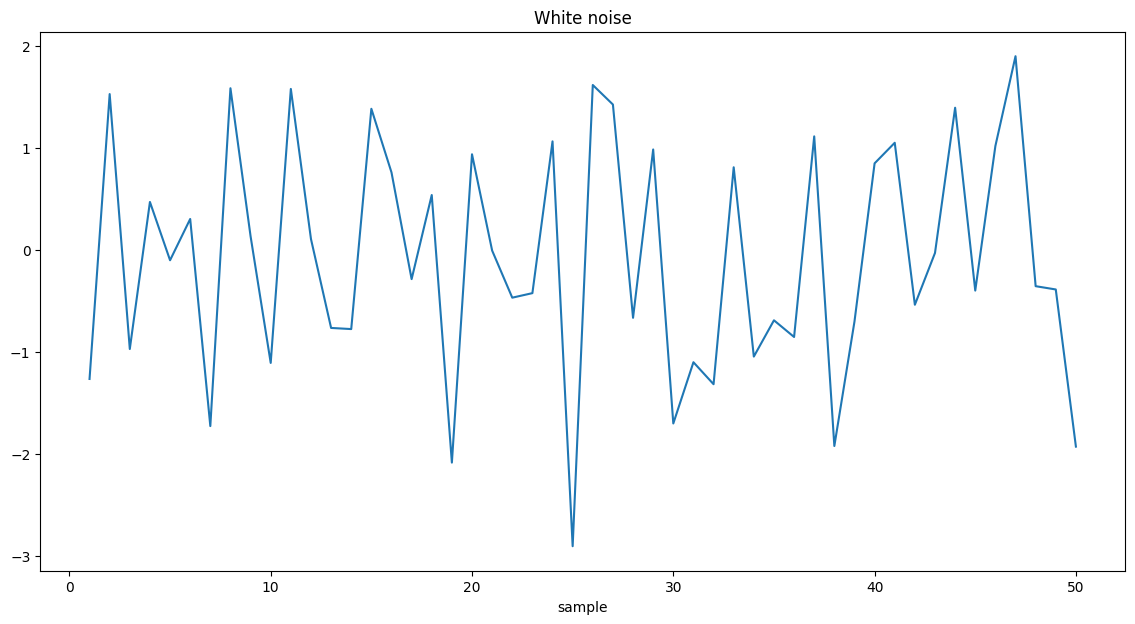

In [252]:
np.random.seed(30)

sample = np.arange(1, 51)
wn = np.random.normal(size=50)

y = pd.DataFrame({'sample': sample, 'wn': wn})

plt.figure(figsize=(14, 7))

sns.lineplot(x='sample', y='wn', data=y)
plt.title("White noise")
plt.ylabel('')
plt.show()


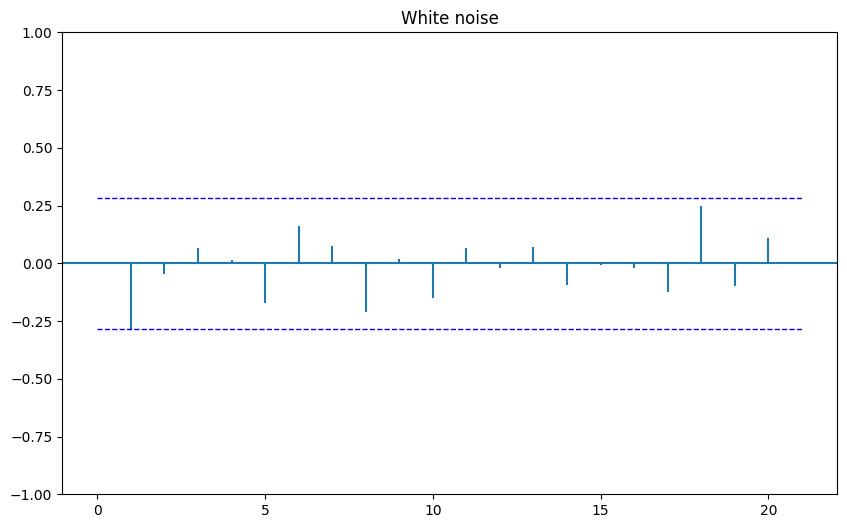

In [253]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(y['wn'], lags=20, alpha=None, ax=ax, title='White noise', zero=False)
for line in ax.get_lines():
    line.set_marker('')

T = len(y['wn'])
conf_int = 2/np.sqrt(T)
ax.hlines(y=[-conf_int, conf_int], xmin=0, xmax=21, colors='b', linestyles='dashed', lw=1)

plt.show()


## Simple forecasting methods to use as baseline

* Prepare the dataset: Bricks produced in Australia

In [52]:
aus_production = pd.read_csv('data/aus_production.csv', sep=" ", parse_dates=['Quarter'])
aus_production.set_index('Quarter', inplace=True)
aus_production.index = aus_production.index.to_period('Q')

In [54]:
start_period = '1970Q1'
end_period = '2004Q4'

bricks = aus_production.loc[start_period:end_period, 'Bricks']

In [55]:
bricks.head()

Quarter
1970Q1    386.0
1970Q2    428.0
1970Q3    434.0
1970Q4    417.0
1971Q1    385.0
Freq: Q-DEC, Name: Bricks, dtype: float64

* Create plot function

In [157]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series

def plot_forecast(model, y, steps_ahead=8):
    fh = ForecastingHorizon([i+1 for i in range(steps_ahead)], is_relative=True)
    y_pred = model.predict(fh)

    pred_ints = model.predict_interval(coverage=0.95)

    plot_series(y, y_pred, labels=["Actual", "Forecast"], pred_interval=pred_ints,
                colors = ["black", "blue"], markers=[",", ","])
    plt.legend()
    plt.show()

### Mean method

* `model` trains specified model definition(s) to a dataset.
* `MEAN` is a model that forecasts future values based on the observed sample mean.

In [155]:
mean_model = NaiveForecaster(strategy="mean")
mean_model.fit(y=bricks)

NaiveForecaster(strategy='mean')

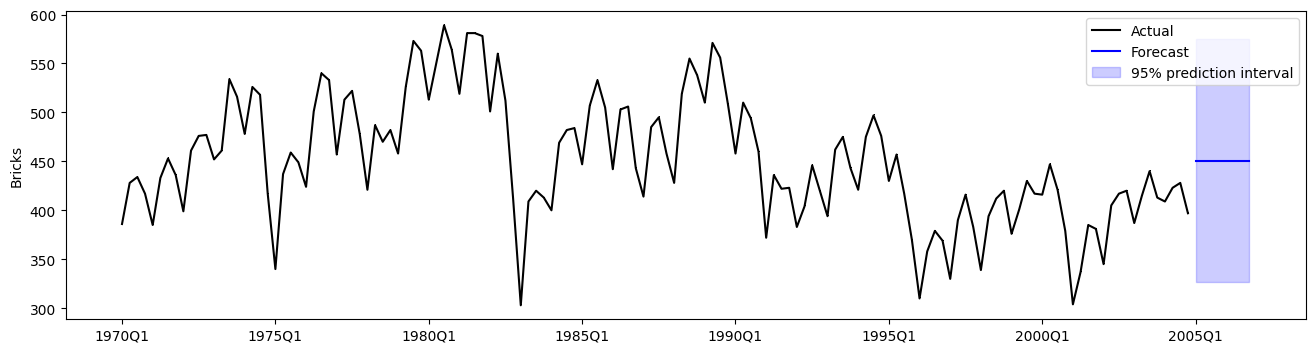

In [158]:
plot_forecast(mean_model, bricks)

### Naive (or random walk) method

In [159]:
naive_model = NaiveForecaster(strategy="last")
naive_model.fit(y=bricks)

NaiveForecaster()

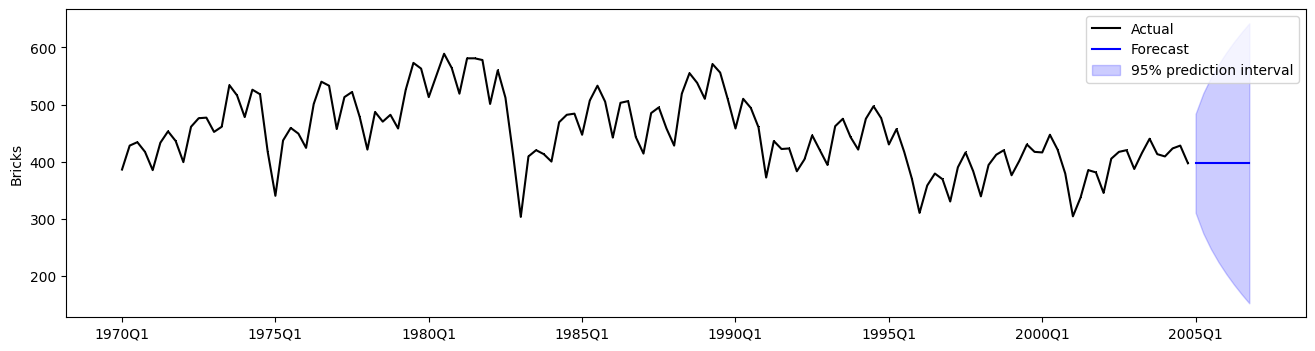

In [160]:
plot_forecast(naive_model, bricks)

### Seasonal naive method

In [161]:
snaive_model = NaiveForecaster(strategy="last", sp=4)
snaive_model.fit(y=bricks)

NaiveForecaster(sp=4)

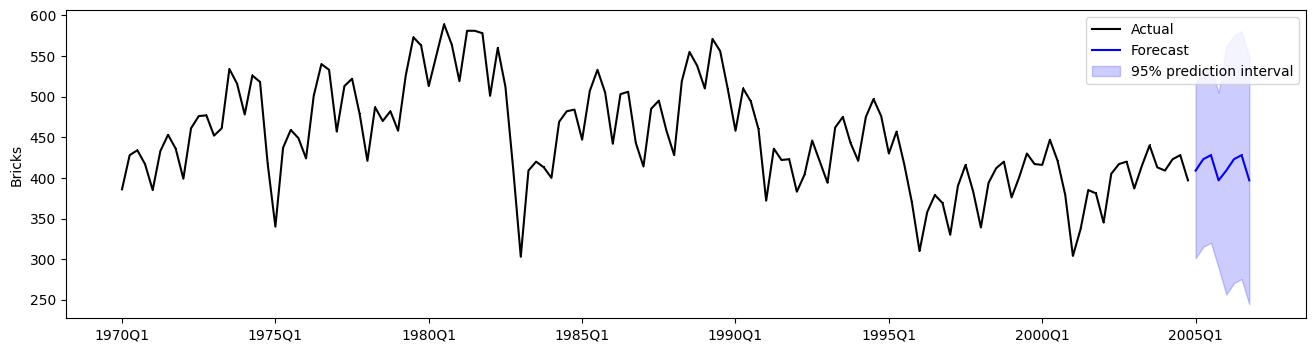

In [162]:
plot_forecast(snaive_model, bricks)

### Drift method

In [163]:
drift_model = NaiveForecaster(strategy="drift")
drift_model.fit(y=bricks)

NaiveForecaster(strategy='drift')

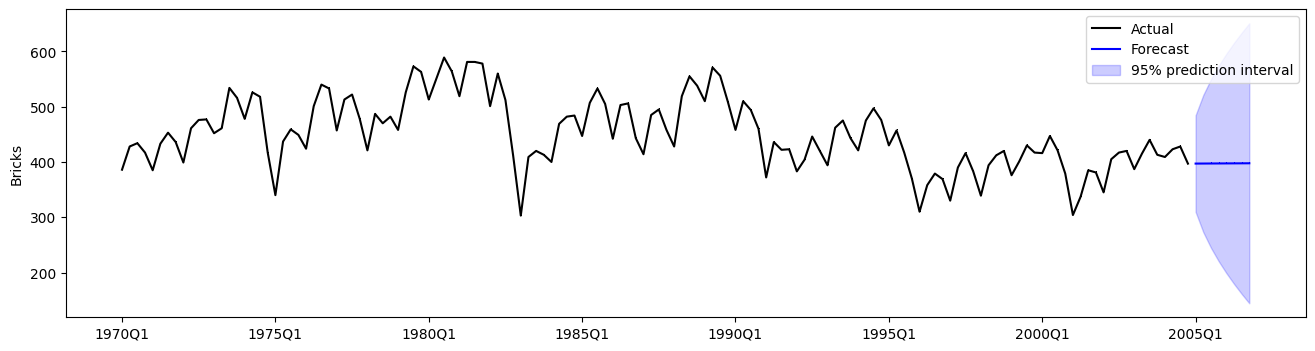

In [164]:
plot_forecast(drift_model, bricks)

* The model fitted values and forecast looks like the ones from the Naive method.
* But lets try to use a different time period:

In [258]:
bricks_1970_1980 = bricks.loc['1970Q1':'1980Q1']
drift_model_1970_1980 = NaiveForecaster(strategy="drift")
drift_model_1970_1980.fit(y=bricks_1970_1980)

NaiveForecaster(strategy='drift')

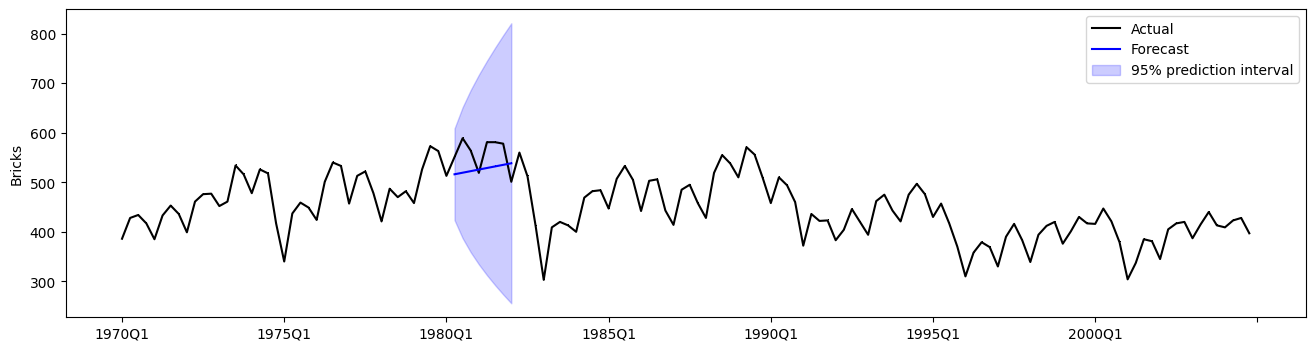

In [259]:
plot_forecast(drift_model_1970_1980, bricks)

### Example: Australian quarterly beer production

In [166]:
train = aus_production['1992Q1':'2006Q4'][['Beer']]

print(pd.concat([train.head(), train.tail()]))

         Beer
Quarter      
1992Q1    443
1992Q2    410
1992Q3    420
1992Q4    532
1993Q1    433
2005Q4    482
2006Q1    438
2006Q2    386
2006Q3    405
2006Q4    491


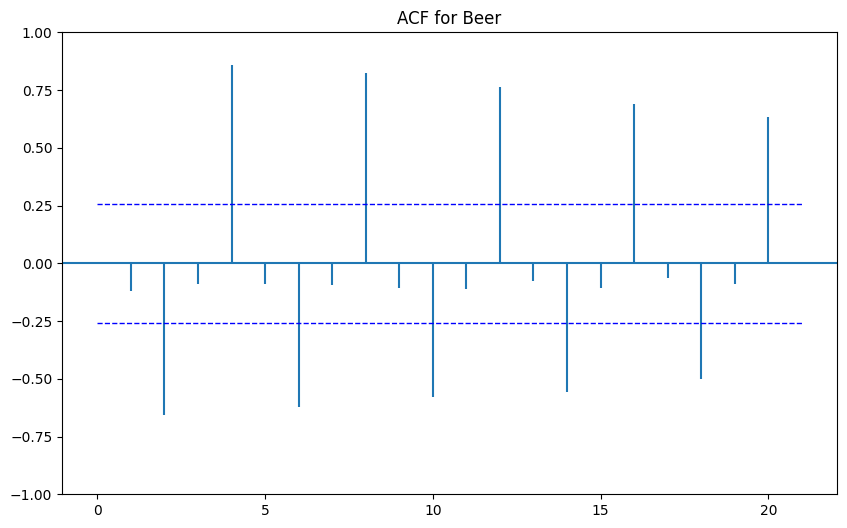

In [215]:
beer_series = train['Beer']

fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(beer_series, lags=20, alpha=None, ax=ax, title='ACF for Beer', zero=False)
for line in ax.get_lines():
    line.set_marker('')

T = len(beer_series)
conf_int = 2 / np.sqrt(T)

ax.hlines(y=[-conf_int, conf_int], xmin=0, xmax=21, colors='b', linestyles='dashed', lw=1)

plt.show()

In [186]:
fh = ForecastingHorizon([i+1 for i in range(14)], is_relative=True)

mean_forecast = mean_model.predict(fh)
naive_forecast = naive_model.predict(fh)
snaive_forecast = snaive_model.predict(fh)

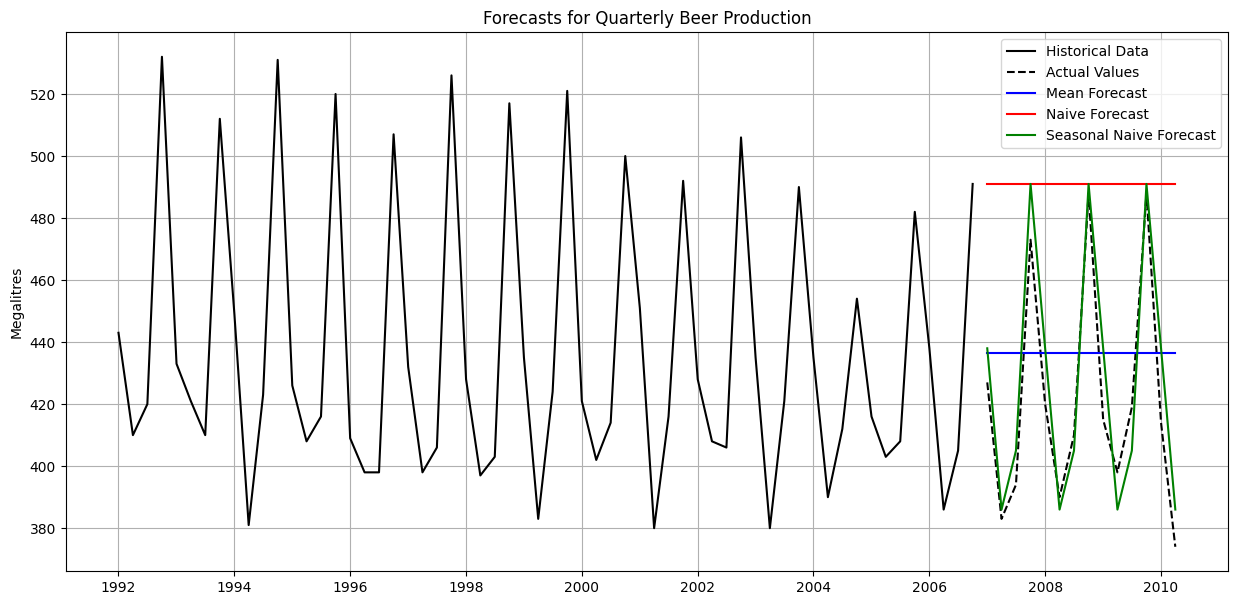

In [195]:
import matplotlib.pyplot as plt

beer_series_dates = beer_series.index.to_timestamp()

mean_forecast_dates = mean_forecast.index.to_timestamp()
naive_forecast_dates = naive_forecast.index.to_timestamp()
snaive_forecast_dates = snaive_forecast.index.to_timestamp()

start_period = '2007Q1'
end_period = aus_production.index[-1].strftime('%YQ%q')
actual_values = aus_production.loc[start_period:end_period, 'Beer']

actual_values_dates = actual_values.index.to_timestamp()

plt.figure(figsize=(15, 7))

plt.plot(beer_series_dates, beer_series, color='black', label='Historical Data')

plt.plot(actual_values_dates, actual_values, color='black', linestyle='dashed', label='Actual Values')

plt.plot(mean_forecast_dates, mean_forecast, color='blue', linestyle='-', label='Mean Forecast')
plt.plot(naive_forecast_dates, naive_forecast, color='red', linestyle='-', label='Naive Forecast')
plt.plot(snaive_forecast_dates, snaive_forecast, color='green', linestyle='-', label='Seasonal Naive Forecast')

plt.title('Forecasts for Quarterly Beer Production')
plt.ylabel('Megalitres')
plt.legend()
plt.grid(True)
plt.show()

### Example: Google’s daily closing stock price

* Use a regular time index instead of an irregular one

In [207]:
gafa_stock = pd.read_csv('data/gafa_stock.csv')
gafa_stock.drop(columns=['Unnamed: 0'], inplace=True)
gafa_stock['Date'] = pd.to_datetime(gafa_stock['Date'])

In [208]:
google_stock = gafa_stock[(gafa_stock['Symbol'] == 'GOOG') & (gafa_stock['Date'].dt.year >= 2015)]

google_stock = google_stock.reset_index(drop=True).reset_index()
google_stock.rename(columns={'index': 'day'}, inplace=True)
google_stock['day'] += 1

google_stock.set_index('day', inplace=True)

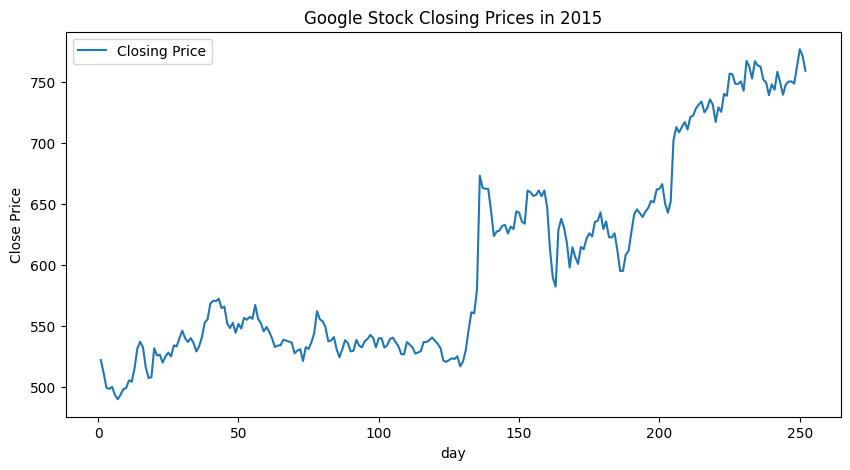

In [211]:
google_2015 = google_stock[google_stock['Date'].dt.year == 2015]

plt.figure(figsize=(10, 5))
plt.plot(google_2015.index, google_2015['Close'], label='Closing Price')
plt.title('Google Stock Closing Prices in 2015')
plt.xlabel('day')
plt.ylabel('Close Price')
plt.legend()
plt.show()

* Plot the ACF

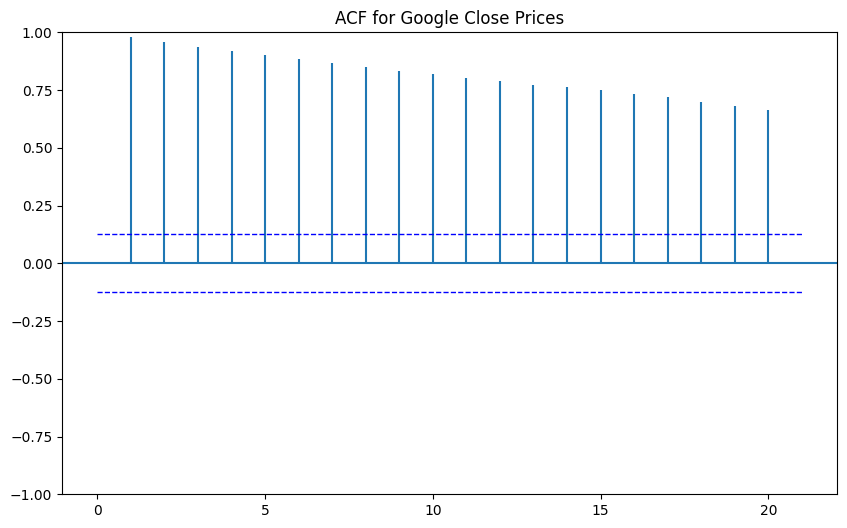

In [214]:
close_prices = google_2015['Close']

fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(close_prices, lags=20, alpha=None, ax=ax, title='ACF for Google Close Prices', zero=False)
for line in ax.get_lines():
    line.set_marker('')

T = len(close_prices)
conf_int = 2 / np.sqrt(T)

ax.hlines(y=[-conf_int, conf_int], xmin=0, xmax=21, colors='b', linestyles='dashed', lw=1)

plt.show()

* Fit mean, naive and drift model to data from 2015

In [223]:
mean_model = NaiveForecaster(strategy="mean")
mean_model.fit(y=close_prices)

naive_model = NaiveForecaster(strategy="last")
naive_model.fit(y=close_prices)

drift_model = NaiveForecaster(strategy="drift")
drift_model.fit(y=close_prices)

NaiveForecaster(strategy='drift')

* Predict values for 2016/Jan, uses `new_data` instead of specifying periods ahead `h`.

In [242]:
google_stock_2016 = google_stock[google_stock.Date.dt.year == 2016]
google_stock_jan_2016 = google_stock_2016[google_stock_2016.Date.dt.month == 1]
jan_2016_days = google_stock_jan_2016.shape[0]

fh = ForecastingHorizon(np.arange(1, jan_2016_days + 1), is_relative=True)

mean_forecast = mean_model.predict(fh)
naive_forecast = naive_model.predict(fh)
drift_forecast = drift_model.predict(fh)

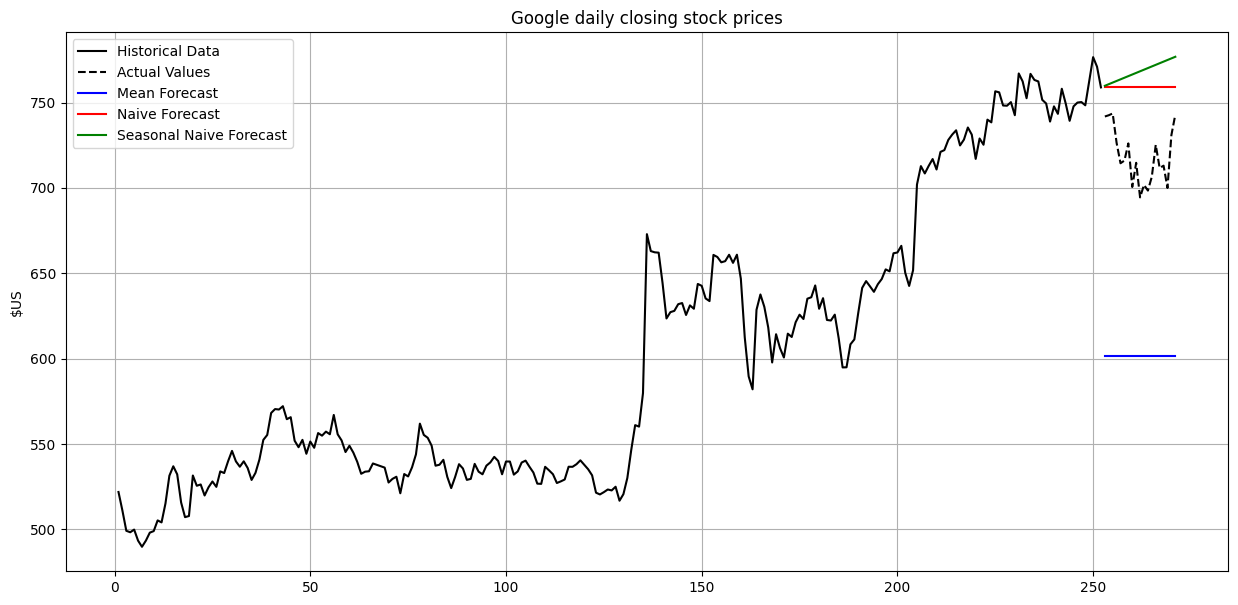

In [244]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))

plt.plot(list(google_2015.index), google_2015['Close'], color='black', label='Historical Data')

plt.plot(list(google_stock_jan_2016.index), google_stock_jan_2016['Close'], color='black', linestyle='dashed', label='Actual Values')

plt.plot(list(mean_forecast.index), list(mean_forecast.values), color='blue', linestyle='-', label='Mean Forecast')
plt.plot(list(naive_forecast.index), list(naive_forecast.values), color='red', linestyle='-', label='Naive Forecast')
plt.plot(list(drift_forecast.index), list(drift_forecast.values), color='green', linestyle='-', label='Seasonal Naive Forecast')

plt.title('Google daily closing stock prices')
plt.ylabel('$US')
plt.legend()
plt.grid(True)
plt.show()